### Propósito: 
- Realizar uma análise exploratória dos dados, afim de encontrar padrões que nos tragam insight para próximas etapas do projeto ( Seleção de Features e Modelagem ).

### Questões: 

● Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

● Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?

● Qual a relação entre Polyphagia e o diagnóstico de diabetes?

Autora: Grazielly de Melo Oliveira



## Dependências

In [25]:
#Importando bibliotecas
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cloudpickle
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.api.types import is_numeric_dtype
from src.eda import plot_correlação
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
cmap = sns.diverging_palette(0,100,74,39,19,25, center='light', as_cmap=True) #heatmap

## Dados e Constantes

In [26]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'diabetes_data.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_NAME = 'train_inter.csv'
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')

In [27]:
#Dados do dicionário
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME), dtype=dicionario_tipo)

## Iniciando Análise Exploratória


In [28]:
df_train.head()

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,fraqueza,polyphagia,candidiase_genital,desfoque_visual,coceira,irritabilidade,cicatrizacao_retardada,paresia_parcial,rigidez_muscular,alopecia,obesidade,target
0,67,male,no,no,no,no,yes,no,yes,no,no,no,no,yes,no,no,negative
1,55,female,yes,yes,yes,no,yes,no,no,yes,no,yes,yes,no,no,no,positive
2,60,male,no,no,no,yes,no,no,no,no,no,no,yes,yes,no,no,negative
3,48,female,yes,yes,no,yes,no,no,yes,yes,no,yes,yes,no,no,no,positive
4,31,female,yes,yes,yes,yes,yes,no,no,yes,yes,no,yes,yes,no,no,positive


In [29]:
df_train.columns

Index(['idade', 'genero', 'polyuria', 'polydipsia', 'perda_de_peso_repentina', 'fraqueza', 'polyphagia', 'candidiase_genital', 'desfoque_visual', 'coceira', 'irritabilidade', 'cicatrizacao_retardada', 'paresia_parcial', 'rigidez_muscular', 'alopecia', 'obesidade', 'target'], dtype='object')

In [30]:
df_train.shape

(416, 17)

In [31]:
#Distribuições das váriaveis numéricas. 
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas

### Apriori para análise de padrões. 

O Apriori trabalha com o conceito de padrões frequentes, criando regras de associação entre o que foi pré estabelecido. 

Umas das medidas de desenpenho consideradas nesta análise é o Lift que indica qual a chance de Y (nosso target) ser dado como positivo, se X (outras features do dataset) for positiva também, e considerando toda a popularidade de Y. Em outras palavras, ele verifica qual informação nos trás mais conhecimento sobre a possibilidade de esses padrões serem encontrados juntos. 


In [32]:
basket_train_features = df_train.drop('idade', axis=1)
dict_convert = {'yes':1, 'no':0, 'female':0, 'male':1, 'negative':0, 'positive':1}
basket_train_features = basket_train_features.applymap(lambda x: dict_convert[x])
for col in basket_train_features.columns.tolist():
    
    basket_train_features[col] = pd.to_numeric(basket_train_features[col])

In [33]:
frequent_itemsets = apriori(basket_train_features, min_support=0.1, use_colnames=True)


In [34]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [35]:
rules[(rules['consequents']=={('target')}) & (rules['lift']>1)].sort_values(by='lift', ascending=False).set_index('antecedents').head(5)

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
antecedents,,,,,,,,
"(cicatrizacao_retardada, polyphagia, paresia_parcial, polydipsia, polyuria, fraqueza)",(target),0.100962,0.615385,0.100962,1.0,1.625,0.038831,inf
"(paresia_parcial, cicatrizacao_retardada, polyuria, fraqueza)",(target),0.144231,0.615385,0.144231,1.0,1.625,0.055473,inf
"(polydipsia, polyphagia, perda_de_peso_repentina)",(target),0.209135,0.615385,0.209135,1.0,1.625,0.080436,inf
"(polydipsia, cicatrizacao_retardada, polyphagia, perda_de_peso_repentina)",(target),0.120192,0.615385,0.120192,1.0,1.625,0.046228,inf
"(polydipsia, cicatrizacao_retardada, perda_de_peso_repentina)",(target),0.149038,0.615385,0.149038,1.0,1.625,0.057322,inf


Com base no lift, e seguindo o top 5 dos sintomas mais presentes para uma maior probabilidade de um pessoa ter o diagnóstico positivo de diabétes é: Possuir juntos: polyuria, polyphagia, cicatrização_retardada, paresia_parcial, fraqueza, polydipsia; em segundo: polyuria, paresia_parcial, fraqueza, cicatrização_retardada; terceiro: perda_de_peso_repentina, polyphagia, polydipsia; quarto: perda_de_peso_repentina, polyphagia, polydipsia, cicatrização_retardada; quinto: perda_de_peso_repentina, cicatrização_retardada, polydipsia. 

## Características Marcantes.

### Observação 

* Estou atribuindo que no target POSITIVO represente 1, e NEGATIVO representa 0. 
* A partir daqui, estou atribuindo que o sexo feminino será representado por 0, e o sexo masculino por 1. 

In [36]:
#Plot da distribuição da variável target.
df_train['target'] = df_train['target'].map({'positive': 1, 'negative': 0})
df_train['genero'] = df_train['genero'].map({'female':0, 'male': 1})

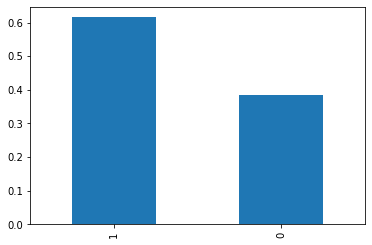

In [37]:
df_train['target'].value_counts(normalize=True).plot.bar()
plt.show()

Plot do target para verificar se há desbalanceamento, para garantir uma melhor métrica de validição na modelagem

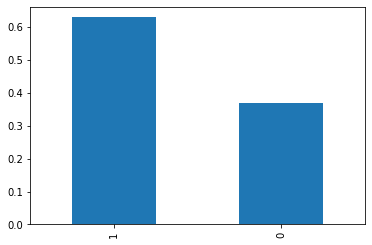

In [38]:
df_train['genero'].value_counts(normalize=True).plot.bar()
#sns.countplot(x="genero", data=df_train,palette="RdYlGn_r")
plt.show()

Na base há mais homens que mulheres.

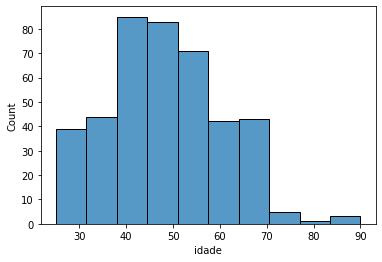

In [39]:
sns.histplot(df_train["idade"], kde=False, bins=10, palette="RdYlGn_r")
plt.show()

In [40]:
df_train["idade"].mean()

48.11298076923077

A maioria das pessoas que estão nesta amostra possuem idade média de 48 anos.

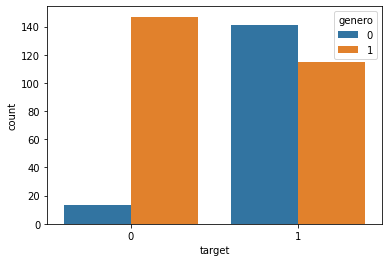

In [41]:
sns.countplot(x='target', hue="genero", data=df_train)
plt.show()

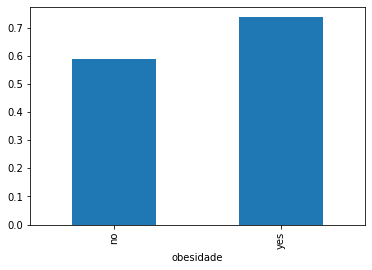

In [42]:
df_train.groupby('obesidade').mean()['target'].plot.bar()
plt.show()

Nesta base, certa de 70% de pessoas que possuem diabetes possuem também obesidade.

## Qual a relação entre Polyphagia e o diagnóstico de diabetes?

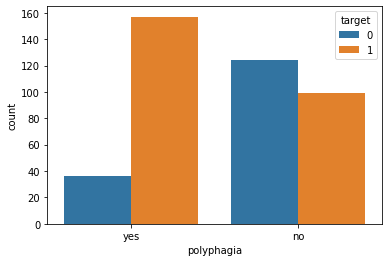

In [43]:
sns.countplot(x='polyphagia', hue="target", data=df_train)
plt.show()

In [44]:
df_train.groupby('polyphagia').mean()['target']*100

polyphagia
no     44.394619
yes    81.347150
Name: target, dtype: float64

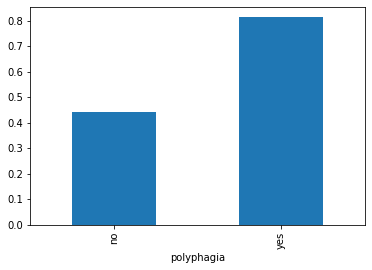

In [45]:
df_train.groupby('polyphagia').mean()['target'].plot.bar()
plt.show()

Polifagia é um sinal médico que significa fome excessiva e ingestão anormalmente alta de sólidos pela boca, pode-se notar que nesta amostra de dados cerca de 80% de pessoas que possuem`polyphagia` também possuem diabetes.

## Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?


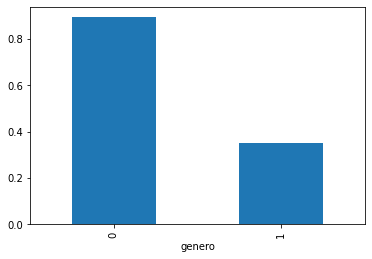

In [46]:
genero_masc = df_train[df_train['genero'] == 1]
genero_masc = df_train[df_train['idade'] < 40]
genero_masc.groupby('genero').mean()['target'].plot.bar()
plt.show()

A chance de uma pessoa do sexo masculino com menos de 40 anos ter diabetes nesta amostra dados é aproximadamente de 35%.

In [47]:
list_yes_no = ['polyuria', 'polydipsia', 'perda_de_peso_repentina', 'fraqueza', 'polyphagia', 'candidiase_genital', 'desfoque_visual', 'coceira', 'irritabilidade', 'cicatrizacao_retardada', 'paresia_parcial', 'rigidez_muscular', 'alopecia', 'obesidade']
for lista in list_yes_no:
    df_train[lista] = df_train[lista].map({"no":0, "yes":1}.get)

/home/graziellymo/Documents/pessoal/Estudo DS/case-sbf-diabetes/src/eda.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  corrmat = df.astype('int').loc[:,lista_de_variaveis].corr(method='pearson')


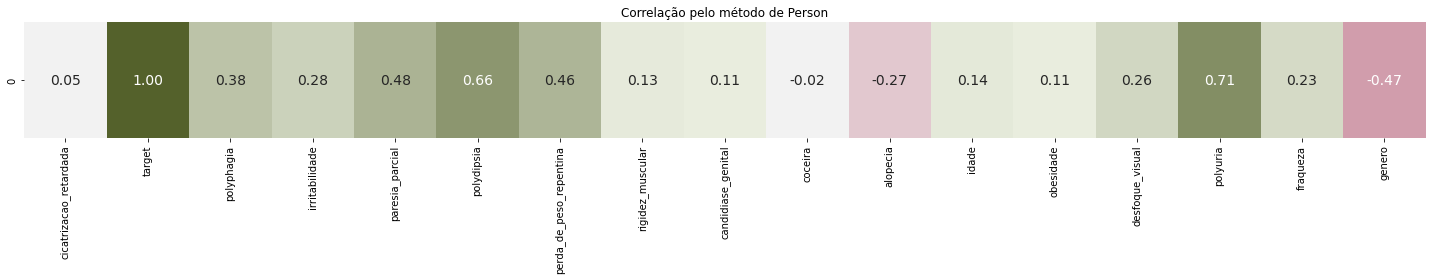

In [48]:
plot_correlação(todas_as_variaveis,df_train)

Afim de verificar a correlação entre o target e as features, para as variáveis catégoricas, O cramer phi é usado para examinar a associação entre duas variáveis categóricas quando há mais de uma contingência.E para as variáveis numérica com método de poit-biserial. Nesses casos, onde as variáveis são categóricas em sua maioria é fundamental a estatística de Cramer, onde o phi de Cramer representa a associação ou correlação entre duas variáveis, equivalente a correlação de pearson (para as categóricas). 

Observação: Os valores do cramer variam entre 0 e 1. Os valores altos de Cramer indicam uma relação mais forte entre as variáveis, e os valores menores indicam uma relação fraca. Um valor de 0 indica que não existe uma associação. Um valor de 1 indica que não há uma associação muito forte entre as variáveis.


Logo pode-se notar que as variáveis `polyuria`, `polydipsia`, e `perda_de_peso_repentina`, possuem uma correlação relativamente alta positiva em relação ao target.